<h1>개인 구글 드라이브와 colab 연동</h1>

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
"""
기존의 코드에서 성능 개선을 하기 위해서 SentimentClassifier내의 FFNN 부분을 수정하였습니다.

1. dropout을 적용
   그 효과로 과적합을 방지하여 모델의 일반화 성능을 향상시키고 모델이 학습 데이터에 과도하게 의존하지 않고 다양한 패턴을 학습할 수 있도록 돕습니다.
2. batch normalization
   그 효과로 학습을 안정화하여 모델의 수렴 속도를 향상시키고 그레이디언트 소실 및 폭주 문제를 완화하여 더 깊은 네트워크에서도 학습을 효과적으로 수행할 수 있도록 합니다.
3. activation function을 ReLU로 변환
   그 효과로 비선형성을 도입하여 모델이 더 복잡한 패턴을 학습할 수 있도록 하고 그레이디언트 소실 문제를 완화하여 학습을 안정화하고, 신속하게 수렴하도록 돕습니다.

이렇게 성능을 개선 시킨 결과를 명확히 보여드리기 위해서 개선 하기 전에 training 과정에서의 loss를 비교할 수 있도록 스크린 샷을 추가하였습니다.
코드의 마지막에는 모델을 training 결과와 test 결과를 따로 보여드리기 위해서 분기하였습니다.
"""

'\n기존의 코드에서 성능 개선을 하기 위해서 SentimentClassifier내의 FFNN 부분을 수정하였습니다.\n\n1. dropout을 적용\n   그 효과로 과적합을 방지하여 모델의 일반화 성능을 향상시키고 모델이 학습 데이터에 과도하게 의존하지 않고 다양한 패턴을 학습할 수 있도록 돕습니다.\n2. batch normalization \n   그 효과로 학습을 안정화하여 모델의 수렴 속도를 향상시키고 그레이디언트 소실 및 폭주 문제를 완화하여 더 깊은 네트워크에서도 학습을 효과적으로 수행할 수 있도록 합니다.\n3. activation function을 ReLU로 변환\n   그 효과로 비선형성을 도입하여 모델이 더 복잡한 패턴을 학습할 수 있도록 하고 그레이디언트 소실 문제를 완화하여 학습을 안정화하고, 신속하게 수렴하도록 돕습니다.\n\n이렇게 성능을 개선 시킨 결과를 명확히 보여드리기 위해서 개선 하기 전에 training 과정에서의 loss를 비교할 수 있도록 스크린 샷을 추가하였습니다.\n코드의 마지막에는 모델을 training 결과와 test 결과를 따로 보여드리기 위해서 분기하였습니다.\n'


개선 전의 Average loss입니다.



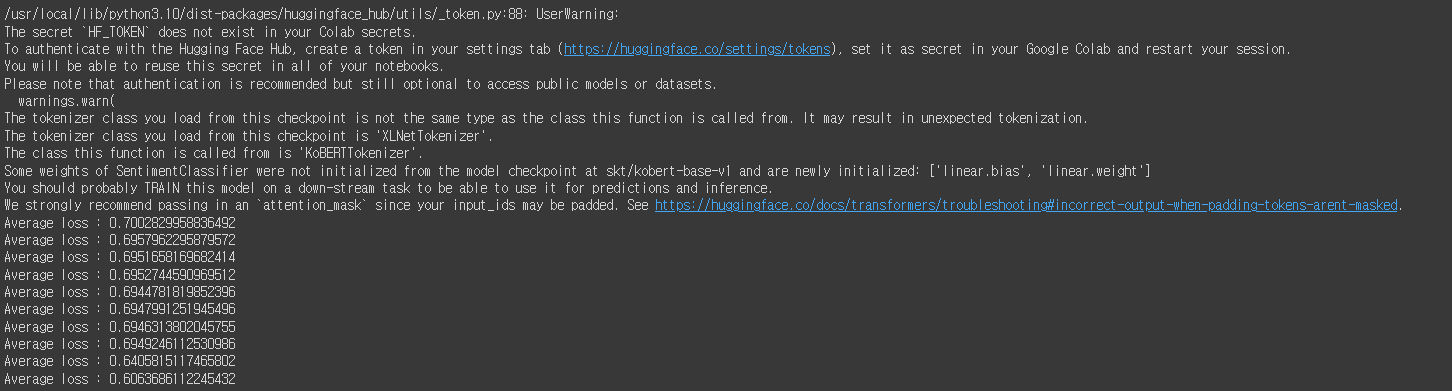

In [ ]:
import os
from IPython.display import Image

root_dir = "/gdrive/MyDrive/NLP/week04"
print('\n개선 전의 Average loss입니다.\n')
Image(os.path.join(root_dir, "개선 전.png"))


개선 전의 Average loss입니다.



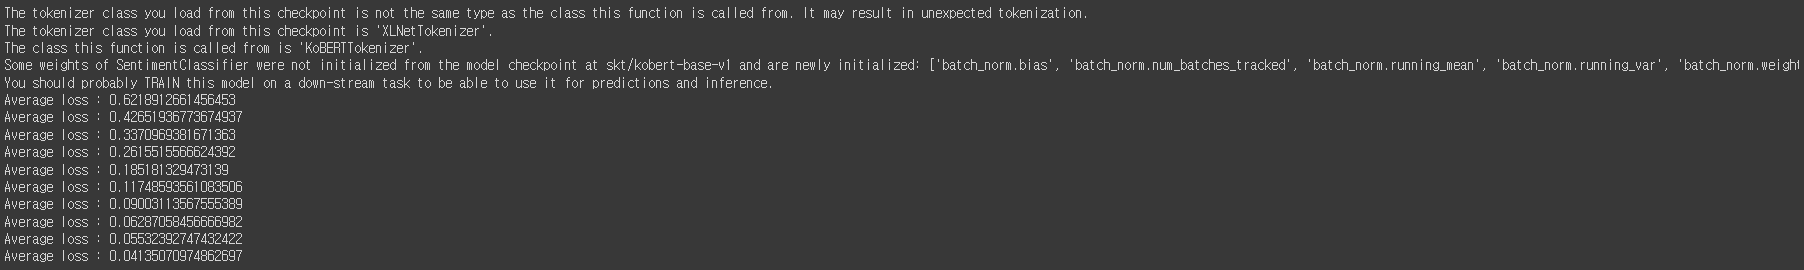

In [ ]:
import os
from IPython.display import Image

print('\n개선 전의 Average loss입니다.\n')
Image(os.path.join(root_dir, "개선 후.png"))

In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-ouyxvb7m/kobert-tokenizer_a383d886ba4344bab796e7e7bc97217d
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-ouyxvb7m/kobert-tokenizer_a383d886ba4344bab796e7e7bc97217d
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=de30805a48ae9a8214fcf649cc423d31f596f71124203581e742bb9746e16164
  Stored in directory: /tmp/pip-ephem-wheel-cache-o2_tlcop/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
!pip install transformers
!pip install sentencepiece

root_dir = "/gdrive/MyDrive/NLP/week04"

import sys

<h1>BERT 모델을 이용한 감성분류</h1>

In [ ]:
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel

class SentimentClassifier(BertPreTrainedModel):
  #pretrained model 상속

    def __init__(self, config):
        super(SentimentClassifier, self).__init__(config)
        #부모의 config 그대로 overriding할 때 bert의 config에 더해 외부에서 주어진 config도 통합

        # BERT 모델 객체화하면서 주어진 config로 초기화
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # 히든 사이즈는 입력받은 config의 hidden_size로 초기화
        self.hidden_size = config.hidden_size

        # 분류할 라벨의 개수도 입력 받은 config의 num_labels로 초기화 (여기서는 2 : Negative, Positive)
        self.num_labels = config.num_labels

        # 활성화 함수 변경 (예: ReLU)
        self.activation = nn.ReLU()

        #cls쪽의 마지막 encoder block에 FFN를 설정하는데 input을 hidden_size로 output을 num_labels로 설계
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.num_labels)

        # 배치 정규화 추가
        self.batch_norm = nn.BatchNorm1d(self.hidden_size)

    def forward(self, input_ids):
        #CLS쪽 마지막 인코더 블럭 층에 FNN 설정해서 classification 학습
        #우리가 입력으로 쓸 wordpiece의 id들을 제공받은 input_ids를 bert 결과로 받기
        outputs = self.bert(input_ids=input_ids)

        # BERT 출력에서 CLS에 대응하는 벡터 표현 추출
        # 선형 함수를 사용하여 예측 확률 분포로 변환

        #(batch_size, max_length, hidden_size)
        bert_output = outputs[0]
        # 0번 인덱스는 마지막 층을 의미해 이를 갖어옴 형식이 (batch_size, max_length, hidden_size) 구조(y축이 batch_size, x축이 max_length(임베딩 최대 크기), z축이 hidden_size)
        #batch 크기로 잘라서 그것들의 평균으로 back propagation 진행(100만개의 데이터라면 10개의 batch로 10만개씩 잘라서 그 10개의 평균으로 back propagation)

        #(batch_size, hidden_size)
        cls_vector = bert_output[:, 0, :]
        #모든 batch와 모든 hidden의 첫 번째가 cls의 embedding vector를 의미


        # 드롭아웃
        cls_vector = self.dropout(cls_vector)

        # 변경된 활성화 함수 적용
        cls_vector = self.activation(cls_vector)

        #class_output
        cls_output = self.linear(cls_vector)

        return cls_output

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. read_data(file_path)</b>
  "train_datas_wordpiece.txt", "test_datas_wordpiece.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    ▁아 ▁더 빙 . . ▁진짜 ▁짜 증 나 네요 ▁목소리 \t negative
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    datas : 영화 리뷰, 정답 라벨
    
    출력 예시)
      datas = [
        (['▁아', '▁더', '빙', '.', '.', '▁진짜', '▁짜', '증', '나', '네요', '▁목소리'], negative)

        (...),
        
        ]
      
<b>2. read_vocab_data(vocab_data_path)</b>
  "label_vocab.txt" 파일을 읽고 라벨을 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_data_path)
  args
    vocab_data_path : 어휘 파일 경로
  return  
    term2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
    idx2term : index를 대응하는 라벨로 치환하기 위한 딕셔너리

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, tokenizer, label2idx)
  args
    datas : 영화 리뷰 데이터와 대응하는 정답 라벨을 갖고 있는 리스트
    max_length : 입력의 최대 길이
    tokenizer : electra tokenizer 객체
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
  return
    input_ids_features : 입력 문장에 대한 index sequence
    label_id_features : 정답을 갖고 있는 리스트
    
  전처리 예시)
    tokenizing된 리뷰 데이터['▁아', '▁더', '빙', '.', '.', '▁진짜', '▁짜', '증', '나', '네요', '▁목소리', ...]
    input_ids : [2, 3360, 28709, 18, 18, 12704, 29334, ... ]
    label_id : [1]
 </pre>


In [ ]:
import torch


def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in lines:
        # 입력 데이터를 \t을 기준으로 분리
        #strip()은 혹시 모를 앞뒤 공백을 먼저 제거하고 \t 기준 분리 (input_sentence, label)로 분리됨
        pieces = line.strip().split("\t")

        # 리뷰(input_sequence), 정답을 분리
        input_sequence, label = pieces[0].split(" "), pieces[1]

        #분리 후에 append하는데 negative는 0, positive는 1로
        datas.append((input_sequence, label))

    return datas


def read_vocab_data(vocab_data_path):
  #dictionary data를 제공
    term2idx, idx2term = {}, {}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()
        #한줄씩 읽어서

    #negative와 positive에 인덱스를 할당(0, 1)
    for line in lines:
        term = line.strip()
        term2idx[term] = len(term2idx)
        idx2term[term2idx[term]] = term
        #term을 추출해 index에 할당

    return term2idx, idx2term

def convert_data2feature(datas, max_length, tokenizer, label2idx):
  #bert는 symbol이 아닌 id로 데이터를 받음
  #data는 read_data()의 입력 문장 데이터, max_length는 임베딩 벡터 최대 크기, tokenizer은 bert 객체 받을 것이고 label을 index로 변환한 것 받기

    input_ids_features, label_id_features = [], []

    for input_sequence, label in datas:
      #datas의 입력 문장과 label로 진행

        # CLS, SEP 토큰 추가
        # 맨 처음인 0번 인덱스에 2번을 의미하는 CLS 토큰 추가(0번이 unk)
        tokens = [tokenizer.cls_token]
        tokens += input_sequence
        #입력 문장의 토큰화된 데이터 리스트를 차례로 넣기

        #맨 마지막인 511번 인덱스에 SEP 토큰 추가하고 입력 데이터 리스트는 510까지만 할당 받고 나머지는 다 잘라야 함.
        tokens = tokens[:max_length - 1]
        tokens += [tokenizer.sep_token]

        # word piece들을 대응하는 index로 치환
        # 입력 문장 데이터의 리스트 요소들인 token들을 알아서 다 token_id로 치환해줌
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # padding 생성 : 할당 안된 게 있다면 1번을 의미하는 pad token으로 채우기
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids))
        input_ids += padding

        #label도 숫자로 변환해서 id로 저장
        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        label_id_features.append(label_id)

        #여기까지가 한 문장을 기준으로 모두 토큰화하고 앞뒤의 cls와 sep, 그리고 한정된 범위내 남은 부분이 있다면 pad로 채우는 과정


    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, label_id_features

<h1>BERT 모델 학습</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BERT 모델 객체 선언 후 사전 학습 파일 불러옴</b>

<b>5. epoch 마다 학습한 모델 파일 저장</b>
</pre>

In [ ]:
import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler)
import torch.optim as optim
import numpy as np

from transformers import BertConfig
# from tokenization_kobert import KoBertTokenizer
from kobert_tokenizer import KoBERTTokenizer



def train(config):
    # BERT config 객체 생성(pretrainedmodel로부터 config를 받아옴)
    bert_config = BertConfig.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                             cache_dir=config["cache_dir_path"])

    #가져온 기존 BERT의 config에 main의 내 config를 추가해서 제공
    setattr(bert_config, "num_labels", config["num_labels"])

    # BERT tokenizer 객체 생성 : convert_data2feature에 넘길 tokenizer
    bert_tokenizer = KoBERTTokenizer.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                     cache_dir=config["cache_dir_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(file_path=config["train_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_label_id_features = convert_data2feature(datas=train_datas,
                                                                             max_length=config["max_length"], #내 config에서 max_length 넘기기
                                                                             tokenizer=bert_tokenizer,#토크나이저 넘기기
                                                                             label2idx=label2idx)     #생성한 라벨 딕셔너리의 label->index 넘기기


    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성 : DataLoader는 데이터를 batch의 크기 단위로 각 요소를 랜덤으로 sampling으로 batch를 만들어주는 객체
    train_dataset = TensorDataset(train_input_ids_features, train_label_id_features)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"],
                                  sampler=RandomSampler(train_dataset))

    # 사전 학습된 BERT 모델 파일로부터 가중치 불러옴 : pretrained model의 가중치로부터 update 하기!
    model = SentimentClassifier.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                cache_dir=config["cache_dir_path"], config=bert_config).cuda()

    # loss를 계산하기 위한 함수 : BCE는 하나의 출력이 0인지 1인지를 분류하는 것이고 여기서는 N과 P인 2개를 분류 추출하는 것 (1, 0) 혹은 (0, 1)
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    for epoch in range(config["epoch"]): #1000개인데 batch가 10개이면 epoch당 100번 반복!
        model.train()
        #학습 모드

        total_loss = []
        for batch in train_dataloader:
            batch = tuple(t.cuda() for t in batch)
            input_ids, label_id = batch
            #batch에서 (input_id, label_id)를 할당받기

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            # 이는 batch마다 back propagation이 발생하니까 reset해야함
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids)
            #softmax를 통해 N과 P의 확률이 나오는데 이런 것들이 batch의 개수만큼 예측이 나옴 (0.7, 0.3) 처럼

            # loss 계산
            loss = loss_func(hypothesis, label_id)
            #예측과 실측의 loss 비교
            #loss function 내부에서는 확률을 label_id의 0과 1처럼 바꿔서 계산 -> (0.7, 0.3)과 (1, 0)을 같이 처리

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            total_loss.append(loss.data.item())

        bert_config.save_pretrained(save_directory=config["output_dir_path"])
        model.save_pretrained(save_directory=config["output_dir_path"])

        print("Average loss : {}".format(np.mean(total_loss)))

<h1>BERT 모델 평가</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BERT 모델 객체 선언 후 기존에 학습한 모델 파일 불러옴</b>

<b>5. 학습한 BERT 모델 평가</b>
</pre>

In [ ]:
import torch
from torch.utils.data import (DataLoader, TensorDataset, SequentialSampler)

from transformers import BertConfig
# from tokenization_kobert import KoBertTokenizer
from kobert_tokenizer import KoBERTTokenizer


def test(config):
    # BERT config 객체 생성
    bert_config = BertConfig.from_pretrained(pretrained_model_name_or_path=config["output_dir_path"],
                                             cache_dir=config["cache_dir_path"])

    # BERT tokenizer 객체 생성 (기존 BERT tokenizer 그대로 사용)
    bert_tokenizer = KoBERTTokenizer.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                     cache_dir=config["cache_dir_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 평가 데이터 읽기
    test_datas = read_data(file_path=config["test_data_path"])
    test_datas = test_datas[:100]

    # 입력 데이터 전처리
    test_input_ids_features, test_label_id_features = convert_data2feature(datas=test_datas,
                                                                           max_length=config["max_length"],
                                                                           tokenizer=bert_tokenizer,
                                                                           label2idx=label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_dataset = TensorDataset(test_input_ids_features, test_label_id_features)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=config["batch_size"],
                                 sampler=SequentialSampler(test_dataset))

    # 학습한 모델 파일로부터 가중치 불러옴
    model = SentimentClassifier.from_pretrained(pretrained_model_name_or_path=config["output_dir_path"],
                                                cache_dir=config["cache_dir_path"], config=bert_config).cuda()

    model.eval()
    #학습 모드

    for batch in test_dataloader:
        batch = tuple(t.cuda() for t in batch)
        input_ids, label_id = batch

        with torch.no_grad():#학습이 아니니까 gradient 없이 진행!
            # 모델 예측 결과
            hypothesis = model(input_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(torch.softmax(hypothesis, dim=-1), dim=-1)
            #[[0, 0], [0, 0], [0,0].....] 이런식으로 있을 것이니 마지막 차원인 맨 안쪽 차원을 기준으로 softmax처리(dim=-1) : 맨 마지막 차원인 이유는 [[],[[],[]]] 이렇게 내부에 중첩되는 차원들이 존재할 수 있기에
            #hypothesis를 softmax한다는 것은 마지막 차원을 기준으로 softmax를 하고 그 결과의 확률 크기를 보고 argmax로 확률값이 가장 큰 인덱스를 추출

        # Tensor를 리스트로 변경 : 해석하기 쉽게 하려고 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        #결과를 찍어내기
        for index in range(len(input_ids)):
            input_tokens = bert_tokenizer.convert_ids_to_tokens(input_ids[index]) #id를 token으로 바꾸기 0->Negative, 1->positive로 가시화
            input_sequence = bert_tokenizer.convert_tokens_to_string(input_tokens[1:input_tokens.index(bert_tokenizer.sep_token)]) #입력 문장도 마찬가지
            predict = idx2label[hypothesis[index]]
            correct = idx2label[label_id[index]]

            print("입력 : {}".format(input_sequence))
            print("출력 : {}, 정답 : {}\n".format(predict, correct))

In [ ]:
import os


if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)


    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train_datas_wordpiece.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas_wordpiece.txt"),
              "output_dir_path":output_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "skt/kobert-base-v1",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 142,
              "epoch":10,
              "batch_size":32
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
Some weights of SentimentClassifier were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['batch_norm.bias', 'batch_norm.num_batches_tracked', 'batch_norm.running_mean', 'batch_norm.running_var', 'batch_norm.weight', 'linear.bias', 'linear.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average loss : 0.6772916554071652
Average loss : 0.5054404890765778
Average loss : 0.4000987414830028
Average loss : 0.32893512852656576
Average loss : 0.27588863544665965
Average loss : 0.22575865927548072
Average loss : 0.1765172156020285
Average loss : 0.14462352623811925
Average loss : 0.11919851652897014
Average loss : 0.1211867697667866


In [ ]:
import os


if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)


    config = {"mode": "test",
              "train_data_path": os.path.join(root_dir, "train_datas_wordpiece.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas_wordpiece.txt"),
              "output_dir_path":output_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "skt/kobert-base-v1",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 142,
              "epoch":10,
              "batch_size":32
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


입력 : 굳 ᄏ
출력 : positive, 정답 : positive

입력 : GDNTOPCLASSINTHECLUB
출력 : positive, 정답 : negative

입력 : 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
출력 : negative, 정답 : negative

입력 : 지루하지는 않은데 완전 막장임... 돈주고 보기에는....
출력 : negative, 정답 : negative

입력 : 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
출력 : negative, 정답 : negative

입력 : 음악이 주가 된, 최고의 음악영화
출력 : positive, 정답 : positive

입력 : 진정한 쓰레기
출력 : negative, 정답 : negative

입력 : 마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다
출력 : negative, 정답 : negative

입력 : 갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다
출력 : negative, 정답 : negative

입력 : 이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..
출력 : positive, 정답 : positive

입력 : 괜찮네요오랜만포켓몬스터[UNK]밌어요
출력 : positive, 정답 : positive

입력 : 한국독립영화의 한계 그렇게 아버지가 된다와 비교됨
출력 : negative, 정답 : negative

입력 : 청춘은 아름답다 그 아름다움은 이성을 흔들어 놓는다. 찰나의 아름다움을 잘 포착한 섬세하고 아름다운 수채화같은 퀴어영화이다.
출력 : positive, 정답 : positive

입력 : 눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다.
출력 : negative, 정답 : positive

입력 : """스토리, 연출, 연